In [4]:
import logging

import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

from utils.load_dataset import load_dataset

tf.get_logger().setLevel(logging.ERROR)
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)

Загрузим данные, разбив на тренировочную, валидационную и тестовую выборки:

In [5]:
train_ds, val_ds, test_ds = load_dataset(os.path.abspath('images'))

Found 19794 files belonging to 40 classes.
Using 13856 files for training.
Found 19794 files belonging to 40 classes.
Using 5938 files for validation.


Загрузим базовую модель MobileNetV2 без верхних слоев:

In [6]:
base_model = tf.keras.applications.MobileNetV2(input_shape=(256, 256, 3),
                                               include_top=False,
                                               weights='imagenet')

Заморозим слои, чтобы веса не обновлялись во время обучения:

In [7]:
base_model.trainable = False

Определим архитектуру нашей модели:

In [8]:
inputs = tf.keras.Input(shape=(256, 256, 3))
preprocess =  tf.keras.layers.Rescaling(1./255)(inputs)
x = base_model(preprocess, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = tf.keras.layers.Dense(40, activation='softmax')(x)
model = tf.keras.Model(inputs, outputs)

In [9]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 256, 256, 3)       0         
                                                                 
 mobilenetv2_1.00_224 (Func  (None, 8, 8, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 40)                51240 

Начнем обучение модели с замороженными нижними слоями:

In [10]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

In [11]:
%%time
history_1 = model.fit(train_ds,
                      epochs=3,
                      validation_data=val_ds)

Epoch 1/3


2024-04-24 15:48:28.357722: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8907
2024-04-24 15:48:28.540980: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-04-24 15:48:30.570110: I external/local_xla/xla/service/service.cc:168] XLA service 0x774e98b66f70 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-04-24 15:48:30.570137: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce GTX 1070, Compute Capability 6.1
2024-04-24 15:48:30.595289: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1713948510.735511  108503 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


433/433 [==============================] - 41s 84ms/step - loss: 3.2550 - accuracy: 0.1511 - val_loss: 2.6196 - val_accuracy: 0.3504
Epoch 2/3
433/433 [==============================] - 35s 79ms/step - loss: 2.3917 - accuracy: 0.3759 - val_loss: 2.0874 - val_accuracy: 0.4922
Epoch 3/3
433/433 [==============================] - 35s 80ms/step - loss: 1.9888 - accuracy: 0.4778 - val_loss: 1.8063 - val_accuracy: 0.5523
CPU times: user 5min 14s, sys: 22.5 s, total: 5min 36s
Wall time: 1min 50s


"Разморозим" глубокие слои и продолжим обучение:

In [12]:
base_model.trainable = True

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
    "my_checkpoints/mobile_net_v2.weights.h5",
    save_weights_only=True)

es = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    min_delta=0,
    patience=2,
    verbose=0,
    mode='auto',
    baseline=None,
    restore_best_weights=True,
    start_from_epoch=0
)

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 256, 256, 3)       0         
                                                                 
 mobilenetv2_1.00_224 (Func  (None, 8, 8, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 40)                51240 

In [13]:
%%time
history_2 = model.fit(train_ds,
                      epochs=17,
                      validation_data=val_ds,
                      callbacks=[checkpoint_cb, es])

Epoch 1/17
433/433 [==============================] - 117s 227ms/step - loss: 1.4145 - accuracy: 0.5906 - val_loss: 1.0645 - val_accuracy: 0.6938
Epoch 2/17
433/433 [==============================] - 97s 224ms/step - loss: 0.8142 - accuracy: 0.7601 - val_loss: 0.8203 - val_accuracy: 0.7687
Epoch 3/17
433/433 [==============================] - 97s 224ms/step - loss: 0.5389 - accuracy: 0.8401 - val_loss: 0.7160 - val_accuracy: 0.7893
Epoch 4/17
433/433 [==============================] - 98s 225ms/step - loss: 0.3724 - accuracy: 0.8891 - val_loss: 0.7323 - val_accuracy: 0.7971
Epoch 5/17
433/433 [==============================] - 98s 225ms/step - loss: 0.2396 - accuracy: 0.9280 - val_loss: 0.7356 - val_accuracy: 0.7968
Epoch 6/17
433/433 [==============================] - 98s 225ms/step - loss: 0.1570 - accuracy: 0.9534 - val_loss: 0.7677 - val_accuracy: 0.8035
Epoch 7/17
433/433 [==============================] - 100s 230ms/step - loss: 0.1247 - accuracy: 0.9633 - val_loss: 0.7613 - val_

In [14]:
results = model.evaluate(test_ds)

93/93 [==============================] - 6s 60ms/step - loss: 0.8067 - accuracy: 0.8085


In [15]:
results

[0.8067160844802856, 0.8084677457809448]

Посомтрим несколько предсказаний:

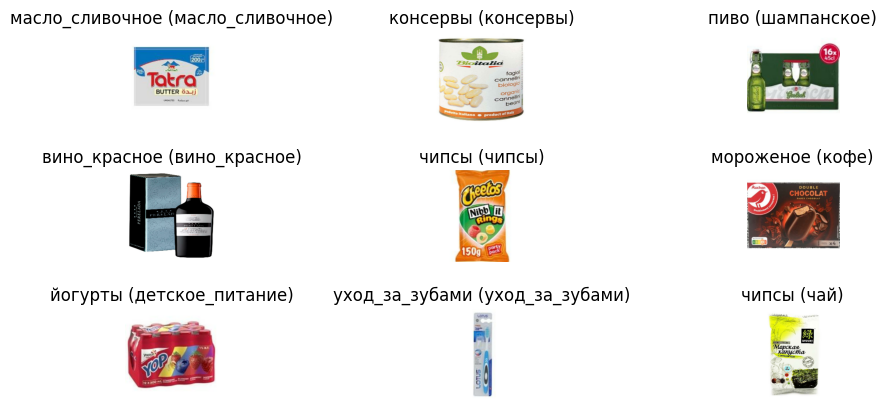

In [19]:
class_names = train_ds.class_names
IMAGE_NUM = 2
for i, (images, labels) in enumerate(test_ds):
    if i == 9:
        break
    ax = plt.subplot(3, 3, i + 1)
    im = np.expand_dims(images[IMAGE_NUM].numpy(), axis=0)
    prediction = class_names[np.argmax(model.predict(im, verbose=0)[0])]
    plt.imshow(images[IMAGE_NUM, ...].numpy().astype("uint8"))
    plt.title(class_names[np.argmax(labels.numpy()[IMAGE_NUM])] + f' ({prediction})')
    plt.axis("off")
    plt.subplots_adjust(left=None, bottom=None, right=1.5, top=None, wspace=None, hspace=0.5)

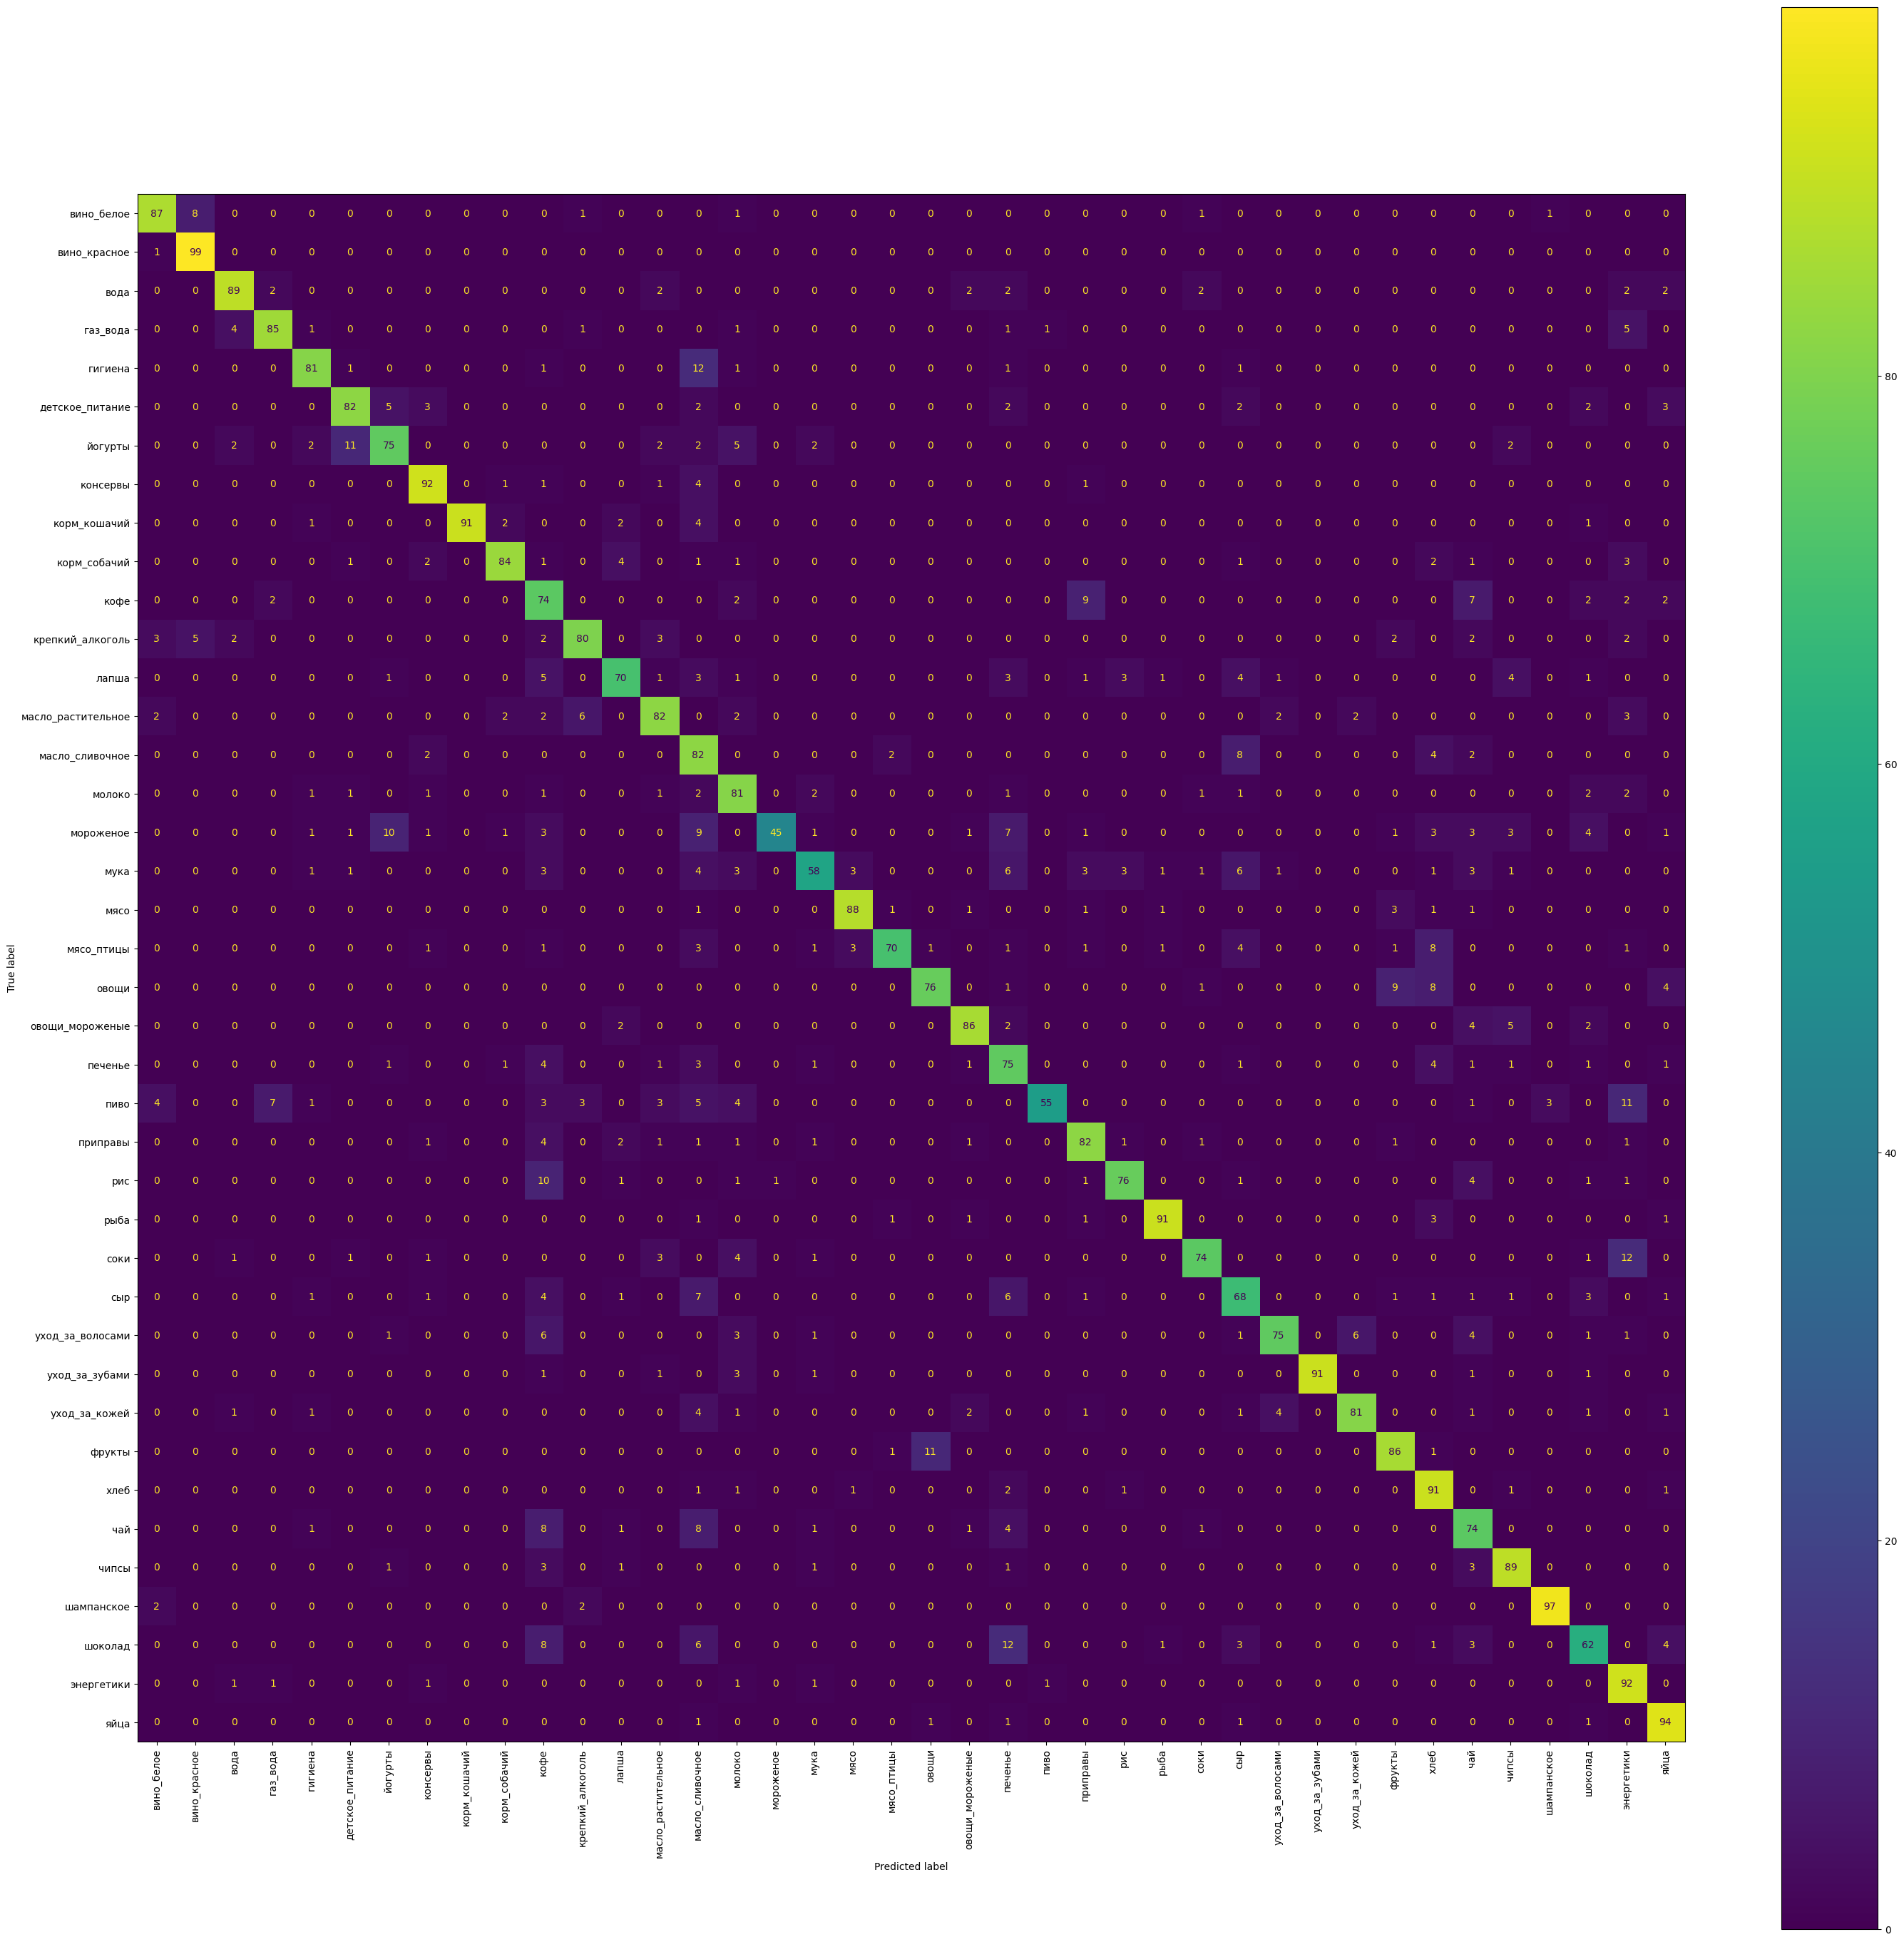

In [20]:
from utils.confusion_matrix import plot_confusion_matrix

plot_confusion_matrix(model, test_ds, train_ds.class_names)

In [21]:
model.save('ready_models/mobile_net_v2.keras')

In [62]:
res_history = {}
for k in history_1.history.keys():
    res_history[k] = history_1.history[k] + history_2.history[k]

In [63]:
import json

with open('models_histories/mobile_net_v2.json', 'w') as f:
    json.dump(res_history, f, indent=4)

Text(0, 0.5, 'Валидационная точность')

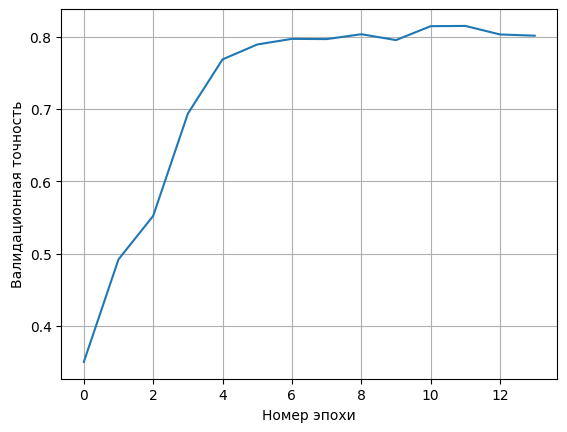

In [64]:
plt.plot(range(len(res_history['accuracy'])), res_history['val_accuracy'])
plt.grid()
plt.xlabel('Номер эпохи')
plt.ylabel('Валидационная точность')